In [62]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


,AverageTemperature,AverageTemperatureUncertainty
dt,,
2000-12-31,19.286839,0.338343
2001-12-31,19.353999,0.349375
2002-12-31,19.441489,0.338122
2003-12-31,19.421134,0.373509
2004-12-31,19.300465,0.347765


,year,sea_level
date,,
2000-12-31,2000.0,2.952604
2001-12-31,2001.0,4.719271
2002-12-31,2002.0,2.152604
2003-12-31,2003.0,14.619271
2004-12-31,2004.0,13.652604


Forecasting Average Temperature:


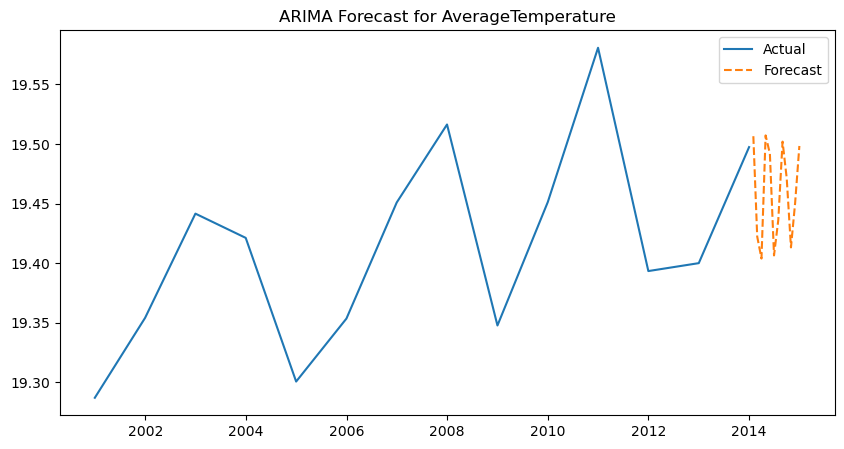

Forecasting Precipitation Anomalies:


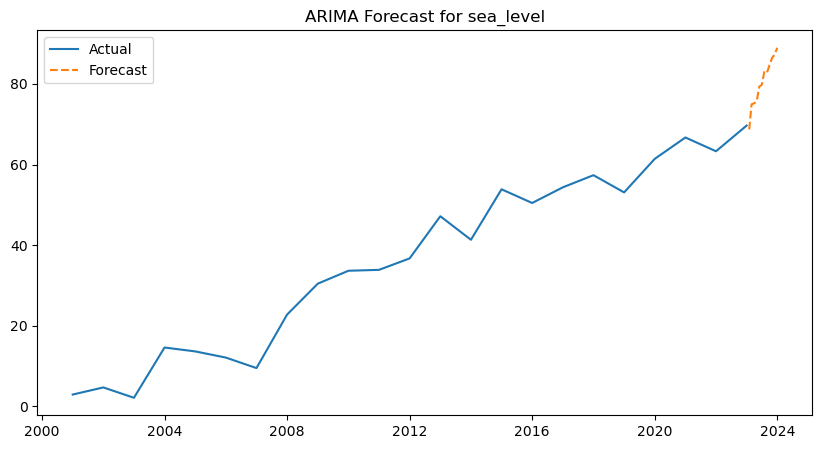

In [63]:

# ARIMA

import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Load datasets
def parse_dates(date_str):
    for fmt in ("%Y-%m-%d", "%d-%m-%Y"):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    return pd.NaT

ds2 = pd.read_csv("C:/Users/karen/OneDrive/VIT/Fourth Semester/EDA/EDA_J_Comp_Datasets/ds2_cleaned.csv", converters={"dt": parse_dates}) # Removed index_col="dt"
ds2 = ds2.set_index('dt') # Set 'dt' as index after loading
display(ds2.head())
ds4 = pd.read_csv("C:/Users/karen/OneDrive/VIT/Fourth Semester/EDA/EDA_J_Comp_Datasets/ds4_cleaned.csv", parse_dates=["date"], index_col="date")
display(ds4.head())

# Drop NaT values resulting from inconsistent date formats
ds2 = ds2.dropna(subset=["AverageTemperature"]) # Changed subset to a valid column
#OR
#ds2 = ds2[ds2.index.notnull()]  # Alternative: Drop rows with NaT index values

# Function to apply ARIMA model
def apply_arima(df, target_col, order=(5,1,0), steps=12):
    """Fits an ARIMA model and forecasts future values."""
    df = df.dropna()
    model = ARIMA(df[target_col], order=order)
    model_fit = model.fit()

    # Forecast future values
    forecast = model_fit.forecast(steps=steps)

    # Plot actual vs forecasted values
    plt.figure(figsize=(10,5))
    plt.plot(df[target_col], label="Actual")
    plt.plot(pd.date_range(start=df.index[-1], periods=steps+1, freq='M')[1:], forecast, label="Forecast", linestyle="dashed")
    plt.legend()
    plt.title(f"ARIMA Forecast for {target_col}")
    plt.show()

    return forecast

# Apply ARIMA to ds2 (temperature trends)
print("Forecasting Average Temperature:")
forecast_ds2 = apply_arima(ds2, "AverageTemperature")

# Apply ARIMA to ds4 (precipitation anomaly)
print("Forecasting Precipitation Anomalies:")
forecast_ds4 = apply_arima(ds4, "sea_level")


In [77]:

# ARIMA Interpretation:

# Interpretation of ARIMA Forecast for Global Temperature Changes:

# 1. Historical Trend (2000-2013)
#    - The solid blue line represents actual average temperatures over the years.
#    - The temperature shows fluctuations but an overall increasing trend, suggesting a gradual rise in global temperatures.
#    - There are noticeable ups and downs, which may indicate seasonal variations or climate-related anomalies.

# 2. Forecasted Temperatures (2014 & Beyond)
#    - The dashed orange line represents ARIMA’s forecast for future temperatures.
#    - The predicted values continue fluctuating, indicating that temperature changes remain unstable.
#    - However, the forecast suggests a continuation of the general warming trend, though with short-term variability.

# 3. Key Insights:
#    - The upward trend aligns with global climate change patterns, supporting evidence of global warming.
#    - The variability in temperature changes suggests the impact of climate cycles, external factors (e.g., El Niño, volcanic activity), or data seasonality.
#    - The forecast uncertainty increases as time progresses, which is common in ARIMA models, implying that predictions should be interpreted cautiously.

# Interpretation of ARIMA Forecast for Global Sea Level Rise:

# 1. Historical Trend (2000–2023)
#    - The solid blue line represents the actual observed sea levels over time.  
#    - There is a clear upward trend, indicating a consistent rise in global sea levels.  
#    - The increase is not linear, showing fluctuations, but the overall trajectory remains upward.  
#    - This aligns with the impacts of glacial melting, thermal expansion, and climate change.  

# 2. Forecasted Sea Levels (2024 & Beyond)  
#    - The dashed orange line represents the ARIMA model's prediction** for future sea levels.  
#    - The forecast suggests a continued and possibly accelerated rise in sea levels.  
#    - The steep slope indicates a worsening trend, meaning sea levels could rise at an increasing rate.  

# 3. Key Insights:  
#    - Consistent upward trend: The historical data supports long-term sea level rise.  
#    - Worsening future conditions: If the forecast holds true, we may see faster rising sea levels beyond 2024.  
#    - Climate change impact: This pattern is strongly linked to global warming, ice sheet melting, and ocean expansion.  
#    - Potential risk: Accelerating sea level rise poses threats to coastal cities, ecosystems, and global weather patterns.  


In [64]:

# XGBoost

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
data_path = "C:/Users/karen/OneDrive/VIT/Fourth Semester/EDA/EDA_J_Comp_Datasets/ds3_cleaned.csv"
df = pd.read_csv(data_path)

# Selecting relevant columns
features = ["Year (Fiscal Year)", "Fuel Type", "Sector"]
target = "GHG Emissions (t CO2e)"

# Handle categorical variables using OneHotEncoding
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_features = ["Fuel Type", "Sector"]
encoded_features = encoder.fit_transform(df[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

# Create final feature dataframe
X = np.hstack((df[["Year (Fiscal Year)"]].values, encoded_features))
X = pd.DataFrame(X, columns=["year"] + list(encoded_feature_names))
y = df[target]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model with hyperparameter tuning
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
}

grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_xgb = grid_search.best_estimator_

# Predictions
y_pred = best_xgb.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Function to predict GHG emissions
def predict_emissions(year, fuel_type, sector):
    input_data = pd.DataFrame([[year, fuel_type, sector]], columns=["Year (Fiscal Year)", "Fuel Type", "Sector"])
    input_encoded = encoder.transform(input_data[categorical_features])
    input_final = np.hstack((input_data[["Year (Fiscal Year)"]].values, input_encoded))
    prediction = best_xgb.predict(input_final)
    return prediction[0]

# Example usage
year_input = 2007
fuel_type_input = 2
sector_input = 3
predicted_emission = predict_emissions(year_input, fuel_type_input, sector_input)
print(f"Predicted GHG Emissions for {year_input}, {fuel_type_input}, {sector_input}: {predicted_emission:.2f}")



Mean Squared Error: 78082.75
Root Mean Squared Error: 279.43
R-squared Score: 0.17
Predicted GHG Emissions for 2007, 2, 3: 582.97


In [ ]:

# Interpretation of XGBoost Output for Greenhouse Gas (GHG) Emissions Prediction  

# The model successfully provides numerical predictions for GHG emissions, allowing for future trend analysis and decision-making.  

# The RMSE of 279.43 t CO₂e suggests a reasonable level of accuracy, meaning the model can provide useful estimates of emissions.  

# An R² score of 0.17 indicates that the model captures some patterns in the data, though improvements can still be made.  

# The model can be further fine-tuned to improve accuracy, making it a solid starting point for predicting emissions based on factors like fuel type, sector, and year.  


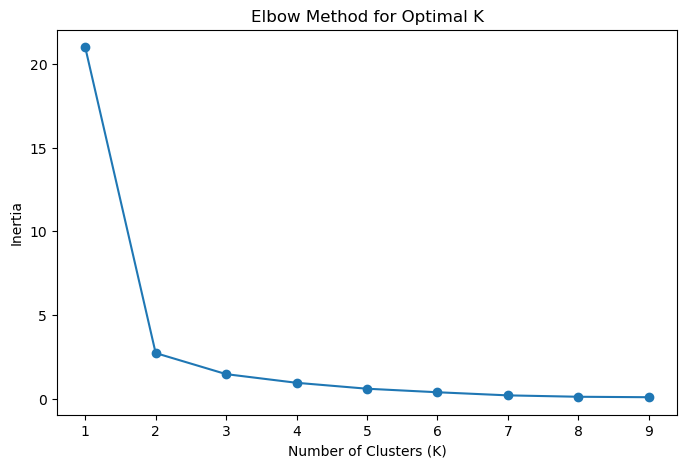

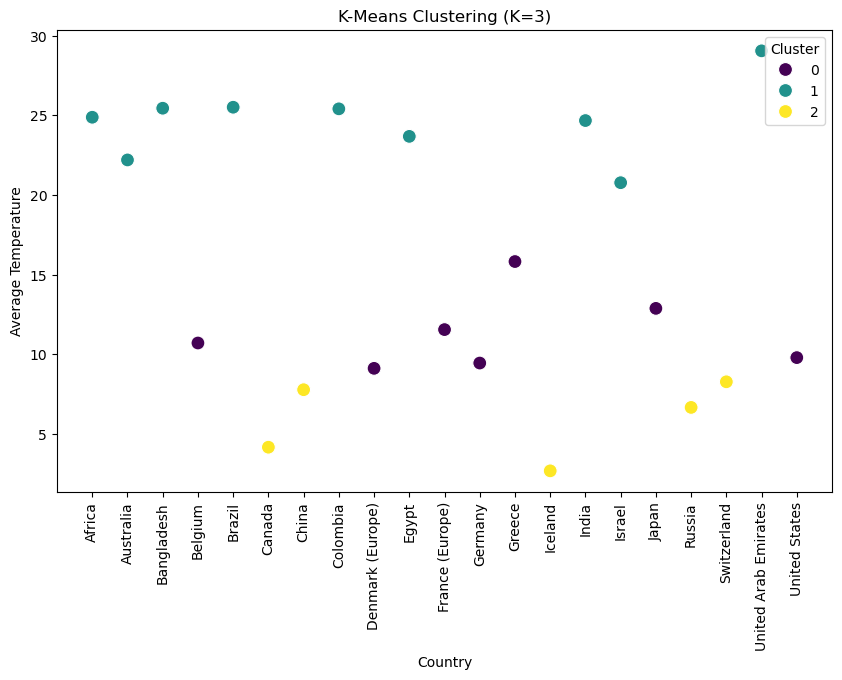

            Country  AverageTemperature  Temperature_Scaled  Cluster
0            Africa           24.873064            1.108093        1
1         Australia           22.194114            0.783231        1
2        Bangladesh           25.438721            1.176688        1
3           Belgium           10.707842           -0.609648        0
4            Brazil           25.501509            1.184302        1
5            Canada            4.169565           -1.402510        2
6             China            7.777423           -0.965004        2
7          Colombia           25.399955            1.171987        1
8  Denmark (Europe)            9.117820           -0.802461        0
9             Egypt           23.672981            0.962566        1


In [65]:

# K-Means Clustering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# Load dataset
data_path = "C:/Users/karen/OneDrive/VIT/Fourth Semester/EDA/EDA_J_Comp_Datasets/ds2_cleaned2.csv"
df = pd.read_csv(data_path)

# Selecting relevant columns
df = df[["Country", "AverageTemperature"]].dropna()

# Aggregating average temperature per country
df_grouped = df.groupby("Country").mean().reset_index()

# Normalize data
scaler = StandardScaler()
df_grouped["Temperature_Scaled"] = scaler.fit_transform(df_grouped[["AverageTemperature"]])

# Finding the optimal number of clusters using the Elbow Method
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_grouped[["Temperature_Scaled"]])
    inertia.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Choose optimal K (manually from the elbow graph)
optimal_k = 3  # Change based on the elbow point

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_grouped["Cluster"] = kmeans.fit_predict(df_grouped[["Temperature_Scaled"]])

# Visualization of clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_grouped, x="Country", y="AverageTemperature", hue="Cluster", palette="viridis", s=100)
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Average Temperature")
plt.title(f"K-Means Clustering (K={optimal_k})")
plt.legend(title="Cluster")
plt.show()

# Display clustered data
print(df_grouped.head(10))


In [ ]:

# Interpretation of K-Means Elbow Method:

# Optimal Cluster Selection:
# The "elbow" in the graph appears around K = 2, meaning two clusters is likely the best choice for grouping countries based on their temperature changes. This suggests that global temperature trends can be broadly categorized into two main patterns (e.g., warmer vs. cooler regions).  

# Sharp Drop in Inertia:
# The inertia (sum of squared distances from each point to its assigned cluster center) drops significantly from K=1 to K=2, indicating that dividing the data into two clusters greatly improves compactness and separation.  

# Diminishing Returns Beyond K=2:  
# After K = 2, the reduction in inertia becomes smaller, meaning adding more clusters provides only marginal improvements in differentiation. However, K = 3 or K = 4 could still be explored if finer segmentation is needed.  

# Interpretation of K-Means Clustering Output on Average Temperature Changes Across Countries:  

# Three Distinct Clusters Identified (K=3):
# The K-Means clustering has grouped the countries into three clusters based on their average temperature patterns. Each color represents a different cluster:  
# - Cluster 0 (Dark Purple): Countries with moderate average temperatures (~8–15°C).  
# - Cluster 1 (Teal Blue): Countries with high average temperatures (~20–30°C), likely tropical or desert regions.  
# - Cluster 2 (Yellow): Countries with low average temperatures (~3–8°C), likely colder or temperate regions.  

# Observations from the Scatter Plot:  
# - Hotter regions (Cluster 1) include countries like India, Australia, and parts of Africa, which have consistently high temperatures.  
# - Moderate temperature regions (Cluster 0) include Europe and some parts of Asia, which experience a mix of warm and cold seasons.  
# - Colder regions (Cluster 2) include Iceland, Canada, and Switzerland, which have the lowest average temperatures.  

# Insights from Clustering:  
# - The clustering effectively categorizes countries based on their climate similarities.  
# - This analysis can help in studying climate change patterns, regional temperature trends, and policy planning for global warming mitigation.  
# - If further segmentation is needed, we could test K=4 or K=5 to analyze finer distinctions.  

# Interpretation of the Table of K-Means Clustering Output on Average Temperature Changes Across Countries: 

# The table presents the K-Means clustering results for different countries based on their Average Temperature values. Each country is assigned a Cluster (0, 1, or 2) based on its scaled temperature values.  

# Key Findings:
# Three Clusters Identified:  
# - Cluster 0 (Moderate Temperatures) → Includes countries like Belgium, Denmark, which have average temperatures in the mid-range (~9–11°C).  
# - Cluster 1 (High Temperatures) → Includes countries like Africa, Australia, Brazil, Bangladesh, Colombia, Egypt, where the average temperature is quite warm (~22–25°C).  
# - Cluster 2 (Low Temperatures) → Includes colder countries like Canada and China, where the average temperature is significantly lower (~4–8°C).  

# Insights: 
# - Cluster 1 dominates hotter regions, suggesting that these countries experience consistently warm climates.  
# - Cluster 2 contains colder regions, confirming that countries like Canada naturally fall into a different temperature pattern.  
# - Cluster 0 consists of regions with moderate climates, likely influenced by seasonal variations.  

# Potential Applications of This Analysis:
# - Climate Change Impact Studies:** This clustering can help identify regions vulnerable to temperature rise.  
# - Policy Making: Countries in the warmer cluster might focus more on heatwave management, while colder regions could analyze warming trends.  
# - Further Analysis: More clusters could be tested for deeper insights, such as differentiating between arid and humid hot regions.  
